In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import v_measure_score

from functions import join_stocks_crypto, run_clustering_model

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [9]:
#Find stocks with over the top volatility
df_all_stocks = pd.read_csv('stocks_data_FINAL.csv',index_col='Date')
df_all_stocks.index = pd.to_datetime(df_all_stocks.index)
df_all_stocks.index = df_all_stocks.index.strftime('%Y-%m-%d')


cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')

cryptos_list = list(cryptos_df.columns)


# log_returns = np.log(df_all_stocks / df_all_stocks.shift(1)).dropna()
# daily_volatility = log_returns.std()
# annual_volatility = daily_volatility * np.sqrt(252)

# annual_volatility.sort_values().tail(20)



# to_drop = ['XSP.F', 'C0V.F', 'OL5.F', 'SMMT', 'H2Y.F', 'GLY.F', 'LPS1.F', 'KO32.F']
# df_all_stocks = df_all_stocks.drop(columns = to_drop)
# df_all_stocks = df_all_stocks.bfill()
# df_all_stocks.to_csv('stocks_data_FINAL.csv')


CLUSTERING INSIGHTS

In [3]:
# map_region_to_country = {'cn_market': 'asia',
#  'crypto': 'crypto',
#  'dr_market': 'eu',
#  'fr_market': 'eu',
#  'gb_market': 'eu',
#  'hk_market': 'asia',
#  'jp_market': 'asia',
#  'nl_market': 'eu',
#  'us_market': 'us'}

# yf_style_crypto_tickers = [ticker.replace('USDT', '-USD') for ticker in cryptos_df.columns]

# df_all_stocks = pd.read_csv('stocks_data_FINAL.csv',index_col='Date')
# cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
# tickers_all = list(df_all_stocks.columns) + list(cryptos_df.columns) 

# exchanges_dict = dict()
# sector_dict = dict()
# market_dict = dict()
# region_dict = dict()
# for ticker in tickers_all:
#     dat = yf.Ticker(ticker)
#     if ticker in list(cryptos_df.columns):
#         exchanges_dict[ticker] = 'crypto'
#         sector_dict[ticker] = 'crypto'
#         market_dict[ticker] = 'crypto'
#         region_dict[ticker] = 'crypto'
#     else:
#         exchange = dat.info['exchange']
#         sector = dat.info['sectorKey']
#         market = dat.info['market']

#         exchanges_dict[ticker] = exchange
#         sector_dict[ticker] = sector
#         market_dict[ticker] = market
#         region_dict[ticker] = map_region_to_country[market]
 

# with open('tickers_with_exchanges.json', 'w') as fp:
#     json.dump(exchanges_dict, fp)

# with open('tickers_with_sectors.json', 'w') as fp:
#     json.dump(sector_dict, fp)

# with open('tickers_with_market.json', 'w') as fp:
#     json.dump(market_dict, fp)

# with open('tickers_with_region.json', 'w') as fp:
#     json.dump(region_dict, fp)

In [10]:
cluster_labels = dict()
for method in ['kshape']:#['ahc', 'kmeans', 'kshape']:
    with open(f'tickers_labels_{method}_final.json') as f:
        clusters = json.load(f)
        cluster_labels[method] = clusters


with open('tickers_with_exchanges.json') as f:
    exchanges_dict = json.load(f)

with open('tickers_with_sectors.json') as f:
    sector_dict = json.load(f)

with open('tickers_with_region.json') as f:
    region_dict = json.load(f)

with open('tickers_with_market.json') as f:
    market_dict = json.load(f)

In [18]:
df = joined_df.rolling(window=14, center=False).mean()
labels, tickers_with_labels_kshape, _, _ = run_clustering_model(df, n_clus=10, model_name='kshape', linkage=None, return_mode='geometric', n_init=3)

cluster_labels['kshape'] = tickers_with_labels_kshape

In [19]:
def visualise_cryptos_in_clusters(ticker_to_class:dict, ticker_to_cluster_all, method, just_cryptos=True, heatmap=False):
    df = pd.DataFrame({
    'Ticker': list(ticker_to_class.keys()),
    'CLASS': [ticker_to_class[t] for t in ticker_to_class],
    'Cluster': [ticker_to_cluster_all[method][t] for t in ticker_to_class]
    })

    if just_cryptos:
        df = df[df['CLASS'] == 'crypto']

    pivot = df.groupby(['Cluster', 'CLASS']).size().unstack(fill_value=0)
    
    if heatmap:
        sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
        plt.title('Heatmap of CLASSES per Cluster')
        plt.xlabel('CLASS')
        plt.ylabel('Cluster')
        plt.tight_layout()
    
    else:
        pivot.plot(kind='bar', stacked=True, colormap='tab20')
        plt.title('CLASS Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Tickers')
        plt.xticks(rotation=0)
        plt.legend(title='CLASS')
        plt.tight_layout()

        
    plt.show()

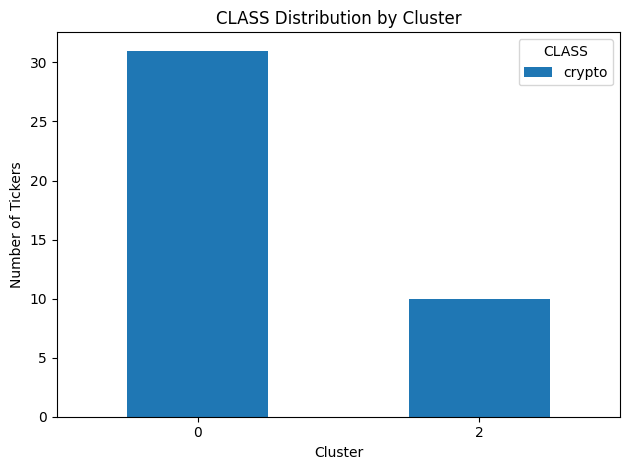

In [20]:
visualise_cryptos_in_clusters(market_dict, cluster_labels, 'kshape', just_cryptos=True, heatmap=False)

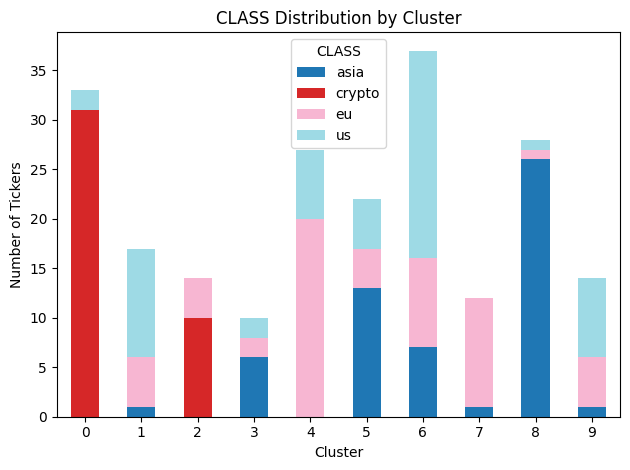

In [14]:
visualise_cryptos_in_clusters(region_dict, cluster_labels, 'kshape', just_cryptos=False, heatmap=False)

In [ ]:
def clustering_v_measure(cluster_dict:dict, class_dict:dict, method:str):
    methods_clusters = cluster_dict[method]

    common = list(set(methods_clusters) & set(class_dict))

    if not common:
        raise ValueError("No overlapping tickers between clustering and class dictionaries.")

    cluster_labels = [methods_clusters[t] for t in common]
    true_labels = [class_dict[t] for t in common]

    v_measure = v_measure_score(true_labels, cluster_labels)
    
    return v_measure

In [21]:
classes_levels = {'exchange': exchanges_dict, 
'sector': sector_dict,
'market': market_dict,
'region': region_dict}


results_economical = pd.DataFrame(columns=['class_labels', 'method', 'v-measure'])
for class_name, class_dict in classes_levels.items():
    for method in ['kmeans', 'kshape', 'ahc']:
        v_measure = clustering_v_measure(cluster_labels, class_dict, method=method)
        print(f'On {class_name} level, for {method}: {v_measure}')

        #add a new row to results:
        results_economical.loc[-1] = [class_name, method, v_measure]
        results_economical.index = results_economical.index + 1 
        results_economical = results_economical.sort_index()

On exchange level, for kmeans: 0.19834997525341638
On exchange level, for kshape: 0.5190538981216157
On exchange level, for ahc: 0.3028582450455175
On sector level, for kmeans: 0.1817511112463155
On sector level, for kshape: 0.46598148207220175
On sector level, for ahc: 0.29170693678029985
On market level, for kmeans: 0.19649090613445538
On market level, for kshape: 0.5443743633741192
On market level, for ahc: 0.2815993092190369
On region level, for kmeans: 0.1524706008642042
On region level, for kshape: 0.5156457603163718
On region level, for ahc: 0.2234046973418282


In [22]:
results_economical

,class_labels,method,v-measure
0,region,ahc,0.223405
1,region,kshape,0.515646
2,region,kmeans,0.152471
3,market,ahc,0.281599
4,market,kshape,0.544374
5,market,kmeans,0.196491
6,sector,ahc,0.291707
7,sector,kshape,0.465981
8,sector,kmeans,0.181751
9,exchange,ahc,0.302858


c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


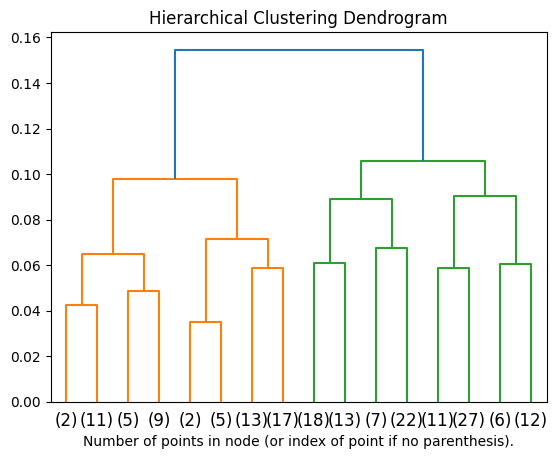

In [12]:
#DO A DENDROGRAM


from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



df_all_stocks = pd.read_csv('stocks_data_new.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')

joined_df.index = pd.to_datetime(joined_df.index)
joined_df_3days = joined_df.resample('3D').last()

df_returns = np.log(joined_df_3days / joined_df_3days.shift(1)).dropna()

df = df_returns.rolling(window=60, center=True).mean().dropna()
#labels, tickers_with_labels_ahc, _, _ = run_clustering_model(df, n_clus=12, model_name='ahc', linkage='complete', return_mode='geometric', n_init=3)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(df)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [13]:
# #GETTING CRYPTOS FROM COINBASE 50 INDEX
# #https://www.marketvector.com/factsheets/download/COIN50.d.pdf


# from binance.client import Client
# import pandas as pd
# from datetime import datetime
# from dateutil.relativedelta import relativedelta
# import time


# def get_binance_close_prices(ticker_list, period=1, start='2024-01-01', interval='1d'):
#     client = Client()

#     start_dt = datetime.strptime(start, '%Y-%m-%d')
#     end_dt = start_dt + relativedelta(years=period)
#     start_str = start_dt.strftime('%d %b %Y')
#     end_str = end_dt.strftime('%d %b %Y')

#     all_closes = {}

#     for ticker in ticker_list:
#         print(f"Fetching data for: {ticker}")
        
#         try:
#             klines = client.get_historical_klines(
#                 ticker, interval, start_str, end_str
#             )

#             if not klines:
#                 continue

#             df = pd.DataFrame(klines, columns=[
#                 'timestamp', 'open', 'high', 'low', 'close', 'volume',
#                 'close_time', 'quote_asset_volume', 'number_of_trades',
#                 'taker_buy_base', 'taker_buy_quote', 'ignore'
#             ])

#             # Convert timestamp and set as index
#             df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
#             df.set_index('timestamp', inplace=True)

#             # Extract close prices
#             df = df[['close']].astype(float)
            


#             all_closes[ticker] = df['close']

#             # Sleep to respect rate limits
#             time.sleep(0.1) 

#         except Exception as e:
#             print(f"Error fetching data for {ticker}: {e}")

#     if not all_closes:
#         print("No data fetched for any tickers. Please check the tickers and date range.")
#         return pd.DataFrame()

#     # Combine data into a single DataFrame
#     df_combined = pd.concat(all_closes, axis=1)

#     return df_combined


# #binance_tickers = [f"{ticker}USDT" for ticker in coinbase_50_cryptos]
# binance_tickers = list(pd.read_csv('cryptos_data_new.csv').columns)

# df = get_binance_close_prices(binance_tickers, start='2021-01-01', period=1)
# #df = df.drop(columns=['HNTUSDT', 'PEPEUSDT', 'APTUSDT', 'BONKUSDT', 'LDOUSDT', 'APEUSDT']).dropna()
